In [9]:
pip install tensorflow opencv-python matplotlib --user

  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Images/DATA

In [18]:
import cv2
import imghdr

In [19]:
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [20]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [21]:
import numpy as np
from matplotlib import pyplot as plt

In [22]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 163 files belonging to 2 classes.


In [23]:
data_iterator = data.as_numpy_iterator()

In [24]:
batch = data_iterator.next()

In [25]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [26]:
batch[1]

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0])

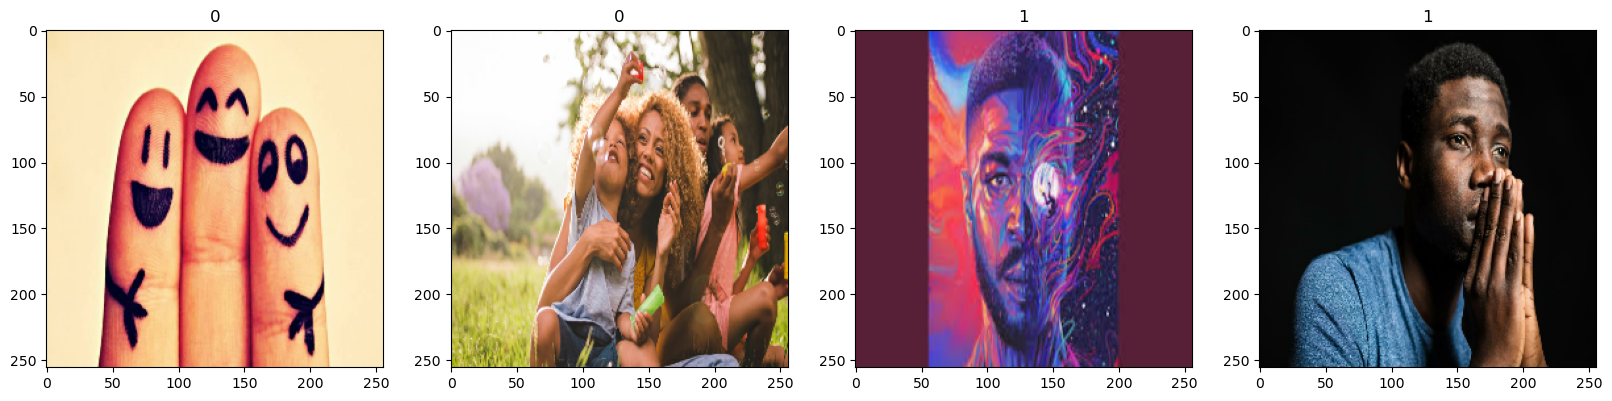

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

preprocessing

In [29]:
#scale data, x are images, y are labels
data = data.map(lambda x,y: (x/255, y))

In [30]:
data.as_numpy_iterator().next()

(array([[[[1.9990120e-03, 2.1368796e-03, 1.6763295e-03],
          [1.9665249e-03, 2.1510692e-03, 1.7512230e-03],
          [1.9973530e-03, 2.1818974e-03, 1.7820513e-03],
          ...,
          [2.4531512e-03, 2.4401913e-03, 2.3012566e-03],
          [1.8455978e-03, 2.0235041e-03, 1.6500935e-03],
          [2.0067880e-03, 2.1913324e-03, 1.7299713e-03]],
 
         [[1.8465623e-03, 2.0772428e-03, 1.6296386e-03],
          [1.8895884e-03, 2.1048901e-03, 1.7050441e-03],
          [1.8997026e-03, 2.1150045e-03, 1.7151582e-03],
          ...,
          [2.0272436e-03, 2.0734221e-03, 1.8288568e-03],
          [2.0586259e-03, 2.0995066e-03, 1.8716288e-03],
          [1.7772714e-03, 1.8873982e-03, 1.5454958e-03]],
 
         [[1.8599373e-03, 2.0752393e-03, 1.6753930e-03],
          [1.8948968e-03, 2.1101986e-03, 1.7384065e-03],
          [1.8575223e-03, 2.0728239e-03, 1.7011747e-03],
          ...,
          [1.9853467e-03, 2.0776191e-03, 1.7393585e-03],
          [2.0683403e-03, 2.0574972e-

split

In [42]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [43]:
train_size,val_size,test_size

(4, 2, 1)

In [45]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

build model

In [46]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [48]:
model = Sequential()

In [49]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)      

train

In [52]:
logdir='logs'

In [53]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [54]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 12s 2s/step - loss: 0.6938 - accuracy: 0.4688 - val_loss: 0.6929 - val_accuracy: 0.6000
Epoch 2/20
4/4 [==============================] - 9s 2s/step - loss: 0.6930 - accuracy: 0.4922 - val_loss: 0.6929 - val_accuracy: 0.4857
Epoch 3/20
4/4 [==============================] - 9s 2s/step - loss: 0.6936 - accuracy: 0.4844 - val_loss: 0.6964 - val_accuracy: 0.4000
Epoch 4/20
4/4 [==============================] - 9s 2s/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6877 - val_accuracy: 0.5714
Epoch 5/20
4/4 [==============================] - 9s 2s/step - loss: 0.6934 - accuracy: 0.5234 - val_loss: 0.6861 - val_accuracy: 0.5714
Epoch 6/20
4/4 [==============================] - 11s 2s/step - loss: 0.6931 - accuracy: 0.5078 - val_loss: 0.6886 - val_accuracy: 0.5429
Epoch 7/20
4/4 [==============================] - 11s 2s/step - loss: 0.6935 - accuracy: 0.4922 - val_loss: 0.6956 - val_accuracy: 0.4286
Epoch 8/20
4/4 [======================

performance

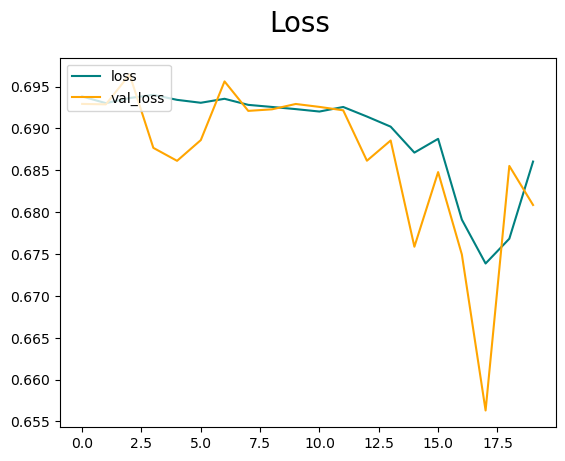

In [55]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

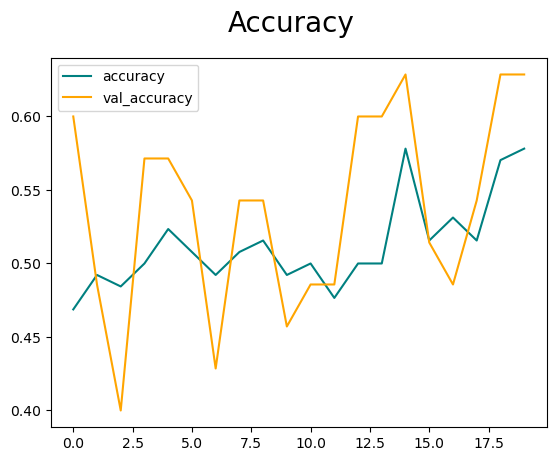

In [56]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

evaluate

In [57]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [58]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [59]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [70]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [66]:
import cv2

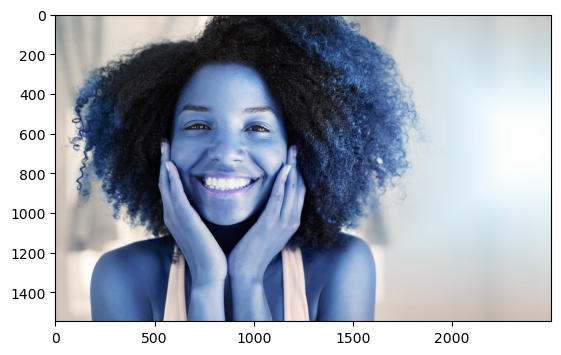

In [72]:
img = cv2.imread('smile.jpg')
plt.imshow(img)
plt.show()

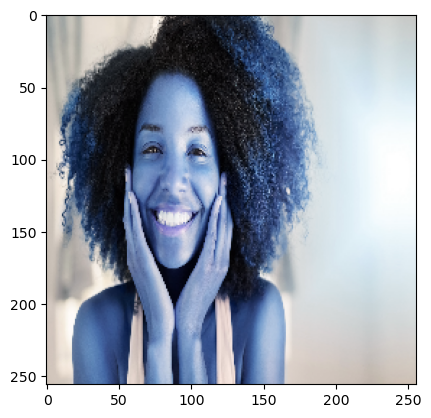

In [73]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [74]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 151ms/step


In [75]:
yhat

array([[0.]], dtype=float32)

In [76]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


In [78]:
from tensorflow.keras.models import load_model

In [86]:
model.save(os.path.join('models','happysad.h5'))

In [88]:
new_model = load_model(os.path.join('models','happysad.h5'))

In [89]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 151ms/step


array([[0.]], dtype=float32)

In [ ]:
yhatnew